<img src="https://www.luxonis.com/logo.svg" width="400">

# Conversion of ONNX Model

## 🌟 Overview
In this tutorial, we'll go through converting a pre-trained ONNX model from [HuggingFace](https://huggingface.co/). We'll first download the model, test its inference, prepare it for deployment on a Luxonis device, and finally test it on a device.

## 📜 Table of Contents
- [🛠️ Installation](#installation)
- [🗃️ Model Download](#model-download)
- [✍ Model Test (Optional)](#model-test)
- [📦 NN Archive](#nn-archive)
- [🗂️ Archive](#archive)
- [🤖 Deploy](#deploy)
- [📷 DepthAI Script](#depthai-script)
- [🗂️ Export without Archive (Optional)](#onnx-export)

<a name="installation"></a>

## 🛠️ Installation

The main focus of this tutorial is using [`ModelConverter`](https://github.com/luxonis/modelconverter) for the conversion of a pre-trained model [`FFNet-54S`](https://huggingface.co/qualcomm/FFNet-54S) from `HuggingFace` models catalog to formats supported by Luxonis devices. `ModelConverter` is our open-source tool for converting all RVC Compiled Formats. Furthermore, we'll also use [`LuxonisML`](https://github.com/luxonis/luxonis-ml) since it provides us with functionality to generate a [`NN Archive`](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/). Finally, we will use [`DepthAI v3`](https://rvc4.docs.luxonis.com/software/) and [`DepthaAI Nodes`](https://rvc4.docs.luxonis.com/software/ai-inference/depthai-nodes/) to run the converted model, process and visualize the results. So, let's not wait any longer and get straight to it!

In [ ]:
%pip install -q pillow luxonis-ml==0.7.1 depthai-nodes==0.3.0 modelconv==0.4.2 -U
%pip install -q depthai==3.0.0rc2 -U

<a name="model-download"></a>

## 🗃️ Model Download

First, let's download the model from `HuggingFace`.

In [3]:
import urllib.request

url = "https://huggingface.co/qualcomm/FFNet-54S/resolve/main/FFNet-54S.onnx"
output_path = "ffnet54s.onnx"

urllib.request.urlretrieve(url, output_path)

('ffnet54s.onnx', <http.client.HTTPMessage at 0x2a439ab1a20>)

<a name="model-test"></a>

## ✍ Model Test (Optional)

It's a good practice to verify the performance of a source model that we want to convert to know that the model is working. This way, when the model is exported and isn't performing well on a device, we know that the problem must lie in the conversion process. 

Image Reference: Pixelwise Instance Segmentation with a Dynamically Instantiated Network - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Sample-results-on-the-Cityscapes-dataset-The-above-images-show-how-our-method-can-handle_fig5_315881952 [accessed 5 Dec 2024]

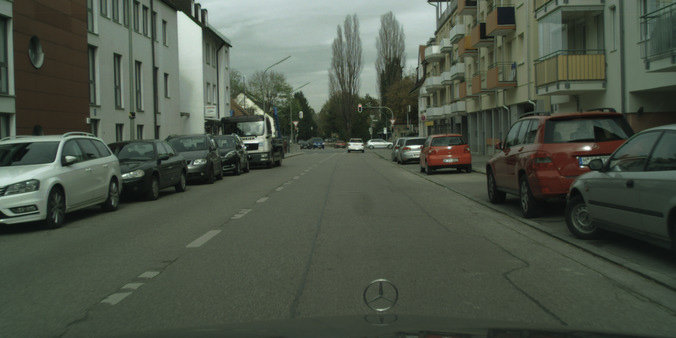

In [4]:
import IPython

img_file = "media/city.jpg"

# Show the image
IPython.display.Image(img_file)

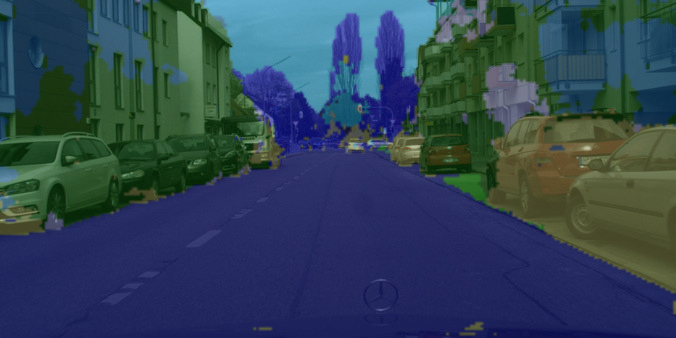

In [5]:
import cv2
import numpy as np
import onnxruntime as ort
import PIL
from PIL import Image


def normalize(img: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    """Normalizes the image"""
    img = img.astype(np.float64) / 255.0
    img = img - mean
    img = img / std
    return img


COLORS = [
    (128, 0, 0),  # class 1 - maroon
    (0, 128, 0),  # class 2 - green
    (128, 128, 0),  # class 3 - olive
    (0, 0, 128),  # class 4 - navy
    (128, 0, 128),  # class 5 - purple
    (0, 128, 128),  # class 6 - teal
    (128, 128, 128),  # class 7 - gray
    (64, 0, 0),  # class 8 - maroon
    (192, 0, 0),  # class 9 - red
    (64, 128, 0),  # class 10 - olive
    (192, 128, 0),  # class 11 - yellow
    (64, 0, 128),  # class 12 - navy
    (192, 0, 128),  # class 13 - fuchsia
    (64, 128, 128),  # class 14 - aqua
    (192, 128, 128),  # class 15 - silver
    (0, 64, 0),  # class 16 - green
    (128, 64, 0),  # class 17 - orange
    (0, 192, 0),  # class 18 - lime
    (128, 192, 0),  # class 19 - yellow
]

# Load the image
raw_image = cv2.imread(img_file)
image = cv2.resize(raw_image, (2048, 1024)).astype(np.float32)
image = normalize(image, mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225]))
image = image.transpose((2,0,1)) # HWC -> CHW
image = np.expand_dims(image, axis=0).astype(np.float32) # CHW -> NCHW

# Load the onnx model
ort_sess = ort.InferenceSession("ffnet54s.onnx")

# Run the inference
outputs = ort_sess.run(None, {'image': image})[0]
# Convert the output to masks
masks = np.argmax(outputs, axis=1)

# Create the mask
mask = np.zeros((masks.shape[1], masks.shape[2], 3), dtype=np.uint8)
for i in range(masks.shape[1]):
    for j in range(masks.shape[2]):
        mask[i,j] = COLORS[masks[0,i,j]]


# Plot the mask
mask = cv2.resize(mask, (raw_image.shape[1], raw_image.shape[0]))
mask = cv2.addWeighted(raw_image, 0.5, mask, 0.5, 0)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
# Visualize the mask
PIL.Image.fromarray(mask)


We have verified that the model returns reasonable predictions, so let's jump into the conversion.

<a name="nn-archive"></a>

## 📦 NN Archive

This section will introduce [`NN Archive`](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/), what it is, and its benefit. `NN Archive` is our own format that packages the model executable(s) and configuration files into a .tar.xz archive. The primary purpose of the `NN Archive` is to describe and specify what the model expects as an input, what the model outputs, and lastly, if and how to process the result. The benefit of the `NN Archive` is seamless integration with our library ecosystem, especially the `DepthAI Nodes` package responsible for processing a model's output. Later in this tutorial, we will experience the benefit of this ourselves.

We will use functions from [`LuxonisML`](https://github.com/luxonis/luxonis-ml) to create the `NN Archive`. The `NN Archive` consists of two parts, model executables (e.g. `ONNX`, `OpenVINO IR`, `TFLite`) and a config encoding the scheme version and a dictionary describing a model's inputs, outputs, heads, and metadata sections. Let's briefly describe each section.

**Inputs**

This section describes all of the model's input(s) and their preprocessing. It's defined as a list of dictionaries. To check out all its fields, please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/#NN%20Archive-Configuration-Inputs).

**Outputs**

This section specifies all the model's output(s). It's defined as a list of dictionaries containing the name and data type of the output data. For more information, refer to our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/#NN%20Archive-Configuration-Outputs).

**Head**

This section configures the post-processing steps applied to the model's output(s). It's again defined as a list of dictionaries. Please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/nn-archive/#NN%20Archive-Configuration-Heads) to learn more about it.

**Metadata**

This section specifies the name of the model, the path to it, and the model's precision.


The creation of a `NN Archive` looks like this:

```python
from luxonis_ml.nn_archive.archive_generator import ArchiveGenerator
from luxonis_ml.nn_archive.config import CONFIG_VERSION


config = {
    "config_version": CONFIG_VERSION,       # Draw config version from luxonis-ml
    "model": {
        "metadata": { ... },                # Specify the model's metadata
        "inputs":   [ { ... }, ... ],       # Specify the model's input stream(s)
        "outputs":  [ { ... }, ... ],       # Specify the model's output stream(s)
        "heads":    [ { ... }, ... ],       # Specify all heads for the model
 }
}

generator = ArchiveGenerator(
    archive_name="...",                     # Name of the generated archive file
    save_path="...",                        # Path to the 
    cfg_dict=config,
    executables_paths=["..."]
)

generator.make_archive()                    # Archive file is saved to the specified save_path
```

<a name="archive"></a>

## 🗂️ Archive

Once we are satisfied with the model's performance, we want to prepare it for deployment on the device. We want to package this exported model into a `NN Archive` as described in the section above.

The code below creates the `NN Archive`.

In [ ]:
from luxonis_ml.nn_archive import ArchiveGenerator
from luxonis_ml.nn_archive.config_building_blocks import (
    DataType,
    InputType,
)
from luxonis_ml.nn_archive.config import CONFIG_VERSION

# Define the configuration dictionary
config = {
    "config_version": CONFIG_VERSION, # draw config version from luxonis-ml
    "model": {
        "metadata": {
            "name": "ffnet54s",
            "path": "ffnet54s.onnx",
            "precision": DataType.FLOAT32
        },
        "inputs": [ # Specify all inputs to the model
            {
                "name": "image",  # Define the input tensor name
                "dtype": DataType.FLOAT32, # Define the input tensor data type
                "input_type": InputType.IMAGE, 
                "shape": [1, 3, 1024, 2048], # Define the input tensor shape
                "layout": "NCHW", # Define the input tensor order
                "preprocessing": {
                    "mean": [123.675, 116.28, 103.53], # Mean values for each channel applied during preprocessing
                    "scale": [58.395, 57.12, 57.375] # Scale values for each channel applied during preprocessing
                }
            }
        ],
        "outputs": [  # Specify all outputs from the model
            {
                "name": "mask", # Define the output tensor name
                "dtype": DataType.FLOAT32, # Define the output tensor data type
                "shape": [1, 19, 128, 256], # Define the output tensor shape
                "layout": "NCHW", # Define the input tensor order
            }
        ],
        "heads": [ # Specify all heads for the model
            {
                "parser": "SegmentationParser", # Define the parser to use from depthai-nodes
                "metadata": {
                    "postprocessor_path": None,
                    "classes": [
                        "road",
                        "sidewalk",
                        "building",
                        "wall",
                        "fence",
                        "pole",
                        "traffic light",
                        "traffic sign",
                        "vegetation",
                        "terrain",
                        "sky",
                        "person",
                        "rider",
                        "car",
                        "truck",
                        "bus",
                        "train",
                        "motorcycle",
                        "bicycle",
                    ],
                    "n_classes": 19,
                    "is_softmax": False
                },
                "outputs": ["mask"] # Define the output tensor to use for the head
            }
        ]
    }
}

archive = ArchiveGenerator(
    archive_name="ffnet54s", # Define string name of the generated archive.
    save_path="./", # Define string path to where you want to save the archive file.
    cfg_dict=config,
    executables_paths=["ffnet54s.onnx"], # Define a list of string paths to relevant model executables.
)
archive.make_archive()

<a name="deploy"></a>

## 🤖 Deploy

Now that we have successfully archived the model, we aim to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. We will show you how to use our [`ModelConverter`](https://github.com/luxonis/modelconverter) to convert the model as simply as possible.


We will use the `ModelConverter` Python API, which leverages our [`HubAI`](https://hub.luxonis.com) platform to perform model conversion in the background. To get started, you'll need to create an account on `HubAI` and obtain your team’s API key.

In [ ]:
HUBAI_API_KEY = "<YOUR_HUBAI_API_KEY>"

Model conversion can be done via either the CLI or the Python API — here, we'll use the latter. For more information, see the [online usage section](https://github.com/luxonis/modelconverter?tab=readme-ov-file#online-usage) of the documentation.

The call below creates a new model card within your team on `HubAI`, uploads the model file and metadata, then performs cloud-side conversion to the selected target platform (e.g., [`RVC2`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc2/), [`RVC4`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc4/)). Once completed, the converted model is automatically downloaded to your device.

For HubAI-specific conversion parameters, refer to the [online conversion section](https://github.com/luxonis/modelconverter/tree/e6a3478ba47d8f92d4d60217f2aee0f4f468cb14/modelconverter/hub#online-conversion) of the ModelConverter documentation. Platform-specific parameters are also documented there.


In [ ]:
from modelconverter import convert

# =============================================================================
# RVC2 conversion
# =============================================================================
converted_model = convert.RVC2(
    api_key=HUBAI_API_KEY,
    path="ffnet54s.tar.xz",
    name="FFNet-54S",
    description_short="Pretrained FFNet-54S on CityScapes",
    tasks=["SEGMENTATION"],
    license_type="MIT",
    is_public=False
)

# Equivalent command using the CLI
# !modelconverter hub login
# !modelconverter hub convert rvc2 --path "ffnet54s.tar.xz" \
#                                 --name "FFNet-54S" \
#                                 --description-short "Pretrained FFNet-54S on CityScapes" \
#                                 --tasks "SEGMENTATION" \
#                                 --license-type "MIT" \
#                                 --no-is-public

# =============================================================================
# RVC4 conversion
# =============================================================================
# converted_model = convert.RVC4(
#     api_key=HUBAI_API_KEY,
#     path="ffnet54s.tar.xz",
#     name="FFNet-54S",
#     description_short="Pretrained FFNet-54S on CityScapes",
#     tasks=["SEGMENTATION"],
#     license_type="MIT",
#     target_precision="FP16",
#     is_public=False
# )

# Equivalent command using the CLI
# !modelconverter hub login
# !modelconverter hub convert rvc4 --path "ffnet54s.tar.xz" \
#                                 --name "FFNet-54S" \
#                                 --description-short "Pretrained FFNet-54S on CityScapes" \
#                                 --tasks "SEGMENTATION" \
#                                 --license-type "MIT" \
#                                 --target-precision "FP16" \
#                                 --no-is-public

We can see for ourselves that this call really created a new model card on `HubAI` with the exported model.

<img src="./media/ffnet_model_exported.png" alt="Exported model on HubAI" width="800">

We have successfully converted our model for RVC2/RVC4 devices, so let's test it on the camera! Please copy the path to the downloaded archive with the converted model from the output log of the appropriate code cell; we will use it in the next section.

In [ ]:
MODEL_PATH = "ffnet-54s-1024x2048-exported-to-rvc2/ffnet54s.rvc2.tar.xz"

<a name="depthai-script"></a>

## 📷 DepthAI Script

To test our model on one of our cameras, we need to have `DepthAI v3` and `Depthai Nodes` installed. Moreover, the following script must be run locally and requires a Luxonis device connected to your machine.

To run the model on a DepthAI device using the script below, please note the following:

- You can view the output stream by opening [http://localhost:8082](http://localhost:8082) in your browser.

- If you're running the script from a Jupyter Notebook, the output may not appear directly within the notebook. The script should print a link pointing to [http://localhost:8082](http://localhost:8082) for accessing the stream.

- To stop the video stream, press **`q`** while focused on the visualizer page.


In [ ]:
from depthai_nodes.node import ParsingNeuralNetwork, ApplyColormap, ImgFrameOverlay
import depthai as dai

DEVICE = None # Set to None to use the default device, or you can specify a specific device IP

device = dai.Device(dai.DeviceInfo(DEVICE)) if DEVICE else dai.Device()
platform = device.getPlatform()
img_frame_type = dai.ImgFrame.Type.BGR888i if platform.name == "RVC4" else dai.ImgFrame.Type.BGR888p
visualizer = dai.RemoteConnection(httpPort=8082)

with dai.Pipeline(device) as pipeline:
    cam = pipeline.create(dai.node.Camera).build()
    nn_archive = dai.NNArchive(MODEL_PATH)
    # Create the neural network node
    nn_with_parser = pipeline.create(ParsingNeuralNetwork).build(
        cam.requestOutput((2048, 1024), type=img_frame_type, fps=30), 
        nn_archive
    )
    # transform output array to colormap
    apply_colormap_node = pipeline.create(ApplyColormap).build(nn_with_parser.out)
    # overlay frames
    overlay_frames_node = pipeline.create(ImgFrameOverlay).build(
        nn_with_parser.passthrough,
        apply_colormap_node.out,
    ) 
    # Configure the visualizer node
    visualizer.addTopic("Video", overlay_frames_node.out, "images")

    # Start pipeline
    pipeline.start()
    visualizer.registerPipeline(pipeline)

    while pipeline.isRunning():
        key = visualizer.waitKey(1)
        if key == ord("q"):
            print("Got q key from the remote connection!")
            break

<a name="onnx-export"></a>

## 🗂️ Export without Archive (Optional)

It is also possible to skip the model archiving and convert the model straight from `ONNX.` However, when running the model on the device, we'd need to define parsers and other parameters manually, so we recommend first creating the `NN Archive` and then converting the model.

In [ ]:
from modelconverter import convert

converted_model = convert.RVC2(
    path="ffnet54s.onnx",
    name="FFNet-54S ONNX",
    description_short="Pretrained FFNet-54S on CityScapes",
    tasks=["SEGMENTATION"],
    license_type="MIT",
    is_public=False
)

Yay! 🎉🎉🎉 Huge congratulations, you have successfully finished this tutorial in which you deployed a pre-trained `FFNet-54S` segmentation model to our cameras!